## Prerequisites

Before starting this tutorial, make sure you have completed the following notebook:

- [`association_data`](./association_data.ipynb):
  This notebook covers the foundational concepts and classes (such as `AData`) that we will build upon in this tutorial.

## Purpose of This Tutorial

In this tutorial, we will explore how to use the **`netbalance`** package to evaluate a custom association prediction model on an arbitrary prediction task—such as **drug–target interaction** or **drug synergy prediction**.

By the end of this tutorial, you will be able to:

- Apply the `netbalance` evaluation framework to **any association prediction task**.
- Integrate and evaluate **any classification model** within this framework.

## Dataset and Task Overview

For this tutorial, we use the **Sanger dataset** for the task of **drug synergy prediction**.  
Our goal is to **train** and **evaluate** a **Random Forest classifier** on this task using the `netbalance` evaluation framework.

## Preparing the Data

To follow this tutorial, you first need to download our **data repository** and place it in the following path:

`path_to_project/src/netbalance/data_repository`

This repository includes:

- The **Sanger dataset** files for drug synergy prediction.
- Precomputed **feature vectors** for drugs and cell lines, borrowed from the *CCSynergy* paper.

> **Note:** These feature vectors will save you time, as they allow you to focus on the evaluation framework rather than feature engineering.

## Tutorial Roadmap

In the following sections, we will go through these steps:

1. [**Define a Dataset Object**](#dataset)
   - Reads drug names, cell line names, and associations from the Sanger dataset.

2. [**Understand `TGData`**](#tgdata) 
   - This class inherits from `AData`, which we explained in our previous tutorial.

3. [**Create Config Objects**](#configs)
   - Store parameters for our model and optimizer.

4. [**Define a Feature Extractor**](#feature-extractor)  
   - Provides an easy way to retrieve features for drugs and cell lines.

5. [**Build a `ModelHandler` Object**](#modelhandler)  
   - Responsible for defining a classifier, using the feature extractor, and making predictions.

6. [**Implement a `HandlerFactory`**](#handler-factory)  
   - A factory that creates `ModelHandler` instances for repeated cross-validation,  
     ensuring a fresh model handler is used in each iteration.

7. [**Define a `Trainer` Class**](#trainer)  
   - Takes a `ModelHandler`, an `OptimizerConfig`, and `TGData`,  
     then trains the model using the given optimizer configuration on the provided data.

8. [**Run Evaluation Framework**](#evaluation-framework)  
   - Train the model and evaluate it using **entity-balanced data** in a repeated cross validation setting.

## Basic Imports

We begin by importing the essential Python libraries required for this tutorial.

In [1]:
import os
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd

## Dataset

Our first task is to define the **`ADataset`** class.  
This class acts as a **handler** for loading and managing our association dataset,  
providing a structured way to access entities (e.g., drugs, cell lines) and their associations.

We have preprocessed the Sanger dataset into three files:

- **`sanger_drug_drug_cell_associations.txt`** – Contains drug–drug–cell line associations.  
- **`cell_line_names.csv`** – Lists all cell line names.  
- **`drug_names.csv`** – Lists all drug names.

We define three constant variables that store the file paths for these processed dataset files.  
This makes it easier to reference them throughout our code without hardcoding paths multiple times.

In [2]:
from netbalance.configs.common import PROCESSED_DATA_DIR

dataset = "sanger"

SANGER_PROCESSED_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, dataset)

SANGER_DATASET_FILE = os.path.join(
    SANGER_PROCESSED_DATA_DIR, "sanger_drug_drug_cell_associations.txt"
)
SANGER_CELL_LINE_NAMES_FILE = os.path.join(
    SANGER_PROCESSED_DATA_DIR, "cell_line_names.csv"
)
SANGER_DRUG_NAMES_FILE = os.path.join(SANGER_PROCESSED_DATA_DIR, "drug_names.csv")

We now define a **`SangerDataset`** class that inherits from `ADataset`.  
`ADataset` already provides `get_association(...)`, but to use it we must implement two abstract methods:

1. **`get_node_names()`**  
   Return the lists of nodes for **each group** in the dataset.  
   Here we have **three groups**:  
   - `drug_A` (first drug in a pair)  
   - `drug_B` (second drug in a pair)  
   - `cell_line`

2. **`get_dataset_file_path()`**  
   Return the path to the **association file** (the file containing drug–drug–cell associations).

We also need to pass the group names to the parent class `ADataset` as implemented in the `__init__` method.

In [3]:
from netbalance.features.bipartite_graph_dataset import ADataset


class SangerDataset(ADataset):

    def __init__(self) -> None:
        super().__init__(["drug1", "drug2", "cell-line"])

    def get_node_names(self):
        return [
            self.get_cluster_a_node_names(),
            self.get_cluster_b_node_names(),
            self.get_cluster_c_node_names(),
        ]

    def get_cluster_a_node_names(self):
        names = pd.read_csv(SANGER_DRUG_NAMES_FILE, index_col=0)
        return list(names.iloc[:, 0])

    def get_cluster_b_node_names(self):
        names = pd.read_csv(SANGER_DRUG_NAMES_FILE, index_col=0)
        return list(names.iloc[:, 0])

    def get_cluster_c_node_names(self):
        names = pd.read_csv(SANGER_CELL_LINE_NAMES_FILE, index_col=0)
        return list(names.iloc[:, 0])

    def get_dataset_file_path(self):
        return SANGER_DATASET_FILE

Once we create a `SangerDataset` object, we can easily access:

- **Associations** – Drug–drug–cell triples from the dataset.  
- **Node names** – The list of entities for each group (drugs and cell lines).  
- **Cluster names** – Group labels corresponding to each entity type.

This allows us to quickly inspect the dataset structure and verify that our loading logic works correctly.

In [4]:
ds = SangerDataset()

associations = ds.get_associations(with_negatives=False)

print(f"Type of associations: {type(associations)}")
print(f"Shape of associations: {associations.shape}")

Type of associations: <class 'numpy.ndarray'>
Shape of associations: (93496, 4)


> **Note**: if we set `with_negatives=True`, it will use all possible associations except positives as negative associations. We can use this option when the dataset lacks negative associations.

In [5]:
associations[:5]  # Each row is a tuple of (drug1, drug2, cell-line, positive/negative)

array([[42, 43, 26,  0],
       [29,  0, 70,  0],
       [34, 57, 59,  0],
       [40, 20, 91,  0],
       [20, 14, 27,  0]], dtype=int32)

In [6]:
ds.cluster_names

['drug1', 'drug2', 'cell-line']

In [7]:
ds.get_cluster_a_node_names()[:10]

['5-Fluorouracil',
 'Afatinib',
 'Alisertib',
 'Alpelisib',
 'Axitinib',
 'AZD4547',
 'AZD6482',
 'AZD7762',
 'AZD8055',
 'BI-2536']

## TGData

In the previous tutorial, we saw how **`AData`** can be used to store and balance data using different methods.

**`TGData`** (**Three-partite Graph Data**) is a subclass of `AData` that is specifically designed for datasets with **exactly three groups** of nodes.  
In our case, these groups are:

1. **Drug A**
2. **Drug B**
3. **Cell Line**

Aside from fixing the number of groups to three, all other functionalities remain the same as in `AData`.

In [8]:
from netbalance.data.association_data import TGData

tg_data = TGData(
    associations=ds.get_associations(),
    cluster_a_node_names=ds.get_cluster_a_node_names(),
    cluster_b_node_names=ds.get_cluster_b_node_names(),
    cluster_c_node_names=ds.get_cluster_c_node_names(),
)

In [9]:
tg_data.associations.shape

(93496, 4)

In [10]:
tg_data.balance_data(balance_method="Balanced")

tg_data.associations.shape

(13684, 4)

In [11]:
print(f"Number of associations after balancing: {tg_data.associations.shape[0]}")
print(
    f"Number of positive associations: {tg_data.associations[tg_data.associations[:, -1] == 1].shape[0]}"
)

Number of associations after balancing: 13684
Number of positive associations: 6842


In our evaluation framework, **`TGData`** can be used to create datasets that are:

- **Balanced** – Equal representation of positive and negative samples.  
- **Entity-balanced** – Ensures each entity (drug or cell line) appears a balanced number of times across folds.  
- **Unbalanced** – Keeps the original distribution of associations without enforcing balance.

This flexibility allows us to test how different balancing strategies affect model performance.

## Configs

For this tutorial, we name our model **`rf_tutorial_model`**.

Each model we define should have its own folder inside:
`data_repository/models/`

We have already created this folder for `rf_tutorial_model` and placed the **CCSynergy** feature files for both drugs and cell lines inside it.

Next, we define a few constant variables:

- **Result directory** – Path for storing the model’s outputs (metrics, logs, plots, etc.).
- **Feature paths** – Locations of the precomputed drug and cell line feature files.

These constants help us keep the code clean and make it easy to switch between models or feature sets without editing multiple code sections.

In [12]:
from netbalance.configs.common import PROCESSED_DATA_DIR

MODEL_NAME = "rf_tutorial_model"

RTM_PROCESSED_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, MODEL_NAME)
RTM_RESULTS_DIR = os.path.join(RTM_PROCESSED_DATA_DIR, "results")

RTM_CELL_FEATURES_DIR = os.path.join(RTM_PROCESSED_DATA_DIR, "features/cells")
RTM_DRUG_FEATURES_DIR = os.path.join(RTM_PROCESSED_DATA_DIR, "features/drugs")

### Model Config

We now define **`RTMModelConfig`**, a class that inherits from `ModelConfig` and stores the parameters of our model (including the feature extractor settings).

For this tutorial, we set the following parameters:

```python
drug_feature_name = "C4"
cell_feature_name = "Cell2"
random_state = 42
```


+ `drug_feature_name` – Name of the drug feature set to use.
+ `cell_feature_name` – Name of the cell line feature set to use.
+ `random_state` – Seed for the Random Forest classifier to ensure reproducibility.

> **Note**: The **CCSynergy** paper provides multiple feature sets for drugs and cell lines.
Here, we explicitly select "C4" for drugs and "Cell2" for cell lines.

In [13]:
from netbalance.configs.general import ModelConfig


class RTMModelConfig(ModelConfig):
    def __init__(self):
        super().__init__()
        self.drug_feature_name = "C4"
        self.cell_feature_name = "Cell2"

        self.random_state = 42

    def get_configuration(self):
        return super().get_configuration() | {
            "drug_feature_name": self.drug_feature_name,
            "cell_feature_name": self.cell_feature_name,
            "random_state": self.random_state,
        }

In [14]:
model_config = RTMModelConfig()

model_config.get_configuration()

{'model_name': None,
 'embed_dim': None,
 'device': None,
 'drug_feature_name': 'C4',
 'cell_feature_name': 'Cell2',
 'random_state': 42}

> **Note:**: the `ModelConfig` class already provides some parameters which we see when using `get_configuration()`. These parameters won't be used in this tutorial.

### Optimizer Config

Next, we define **`RTMOptimizerConfig`**, a class that inherits from `OptimizerConfig` and stores the parameters used to train our model.

For this tutorial, we only need a minimal configuration:

```python
threshold = 0.5
```
+ `threshold` – The threshold for classifying associations as positive or negative.

Since we are using a Random Forest model without complex training schedules or learning rates,
no additional optimizer parameters are required.

In [15]:
from netbalance.configs.general import OptimizerConfig


class RTMOptimizerConfig(OptimizerConfig):

    def __init__(self) -> None:
        super().__init__()
        self.threshold = 0.5

    def get_configuration(self):
        return super().get_configuration()

In [16]:
optimizer_config = RTMOptimizerConfig()

optimizer_config.get_configuration()

{'optimizer': None,
 'lr': None,
 'batch_size': None,
 'n_epoch': None,
 'exp_name': None,
 'save': False,
 'save_path': None,
 'device': 'cpu',
 'report_size': 100,
 'threshold': 0.5}

## Feature Extractor

We now define **`RTMFeatureExtractor`**, a class that inherits from `FeatureExtractor`.  
This class is responsible for preparing and serving features to our model.

It implements two key methods:

1. **`build()`**  
   - Called when we want to train the model.  
   - Loads the drug and cell line features from files (specified in the model configuration).

2. **`extract_features(a_nodes, b_nodes, c_nodes)`**  
   - Takes three lists of nodes.  
   - Retrieves the corresponding feature vectors for each node.  
   - Concatenates these vectors into a single feature vector for each triplet,  
     so that the model can directly use it for prediction.

---

**Why this matters:**  
By separating **feature loading** (`build`) from **feature retrieval** (`extract_features`),  
we ensure that features are loaded only once and can be efficiently reused during training and evaluation.


In [17]:
from netbalance.methods.general import FeatureExtractor


class RTMFeatureExtractor(FeatureExtractor):

    def __init__(
        self,
        drug_feature_name,
        cell_feature_name,
    ):
        super().__init__()

        self.drug_feature_name = drug_feature_name
        self.cell_feature_name = cell_feature_name
        self.drug_file = Path(f"{RTM_DRUG_FEATURES_DIR}/{drug_feature_name}.txt")
        self.cell_file = Path(f"{RTM_CELL_FEATURES_DIR}/{cell_feature_name}.txt")

    def build(self):
        self.drug_features = np.loadtxt(self.drug_file, delimiter=",")
        self.cell_features = np.loadtxt(self.cell_file, delimiter=",")

    def extract_features(
        self,
        a_nodes: Union[list[int], np.ndarray],
        b_nodes: Union[list[int], np.ndarray],
        c_nodes: Union[list[int], np.ndarray],
    ):
        d1 = self.drug_features[a_nodes]
        d2 = self.drug_features[b_nodes]
        c = self.cell_features[c_nodes]
        features = np.concatenate([d1, d2, c], axis=1)
        return features

In [18]:
fe = RTMFeatureExtractor(
    drug_feature_name=model_config.drug_feature_name,
    cell_feature_name=model_config.cell_feature_name,
)
fe.build()

features = fe.extract_features(  # Here we want to extract features for [0, 3, 6] and [1, 4, 7] triplets
    a_nodes=[0, 1],
    b_nodes=[3, 4],
    c_nodes=[6, 7],
)

print(f"Type of features: {type(features)}")
print(f"Shape of features: {features.shape}")

Type of features: <class 'numpy.ndarray'>
Shape of features: (2, 356)


## ModelHandler

A **Model Handler** encapsulates **both** the classifier and the **feature extractor**, and exposes a uniform API to **predict**, and **summarize** models within the evaluation framework.

In our case, `RTMModelHandler` will:

- Hold a **Random Forest** classifier.
- Hold the **`RTMFeatureExtractor`**.
- Implement prediction using these two components.

### Methods to implement

- **`predict_impl(node_lists)`**  
  Given three lists of nodes, use the feature extractor to obtain features and return model scores/probabilities.

- **`destroy()`**  
  Clean up large objects (model, feature extractor caches) after each cross-validation fold to free memory.

- **`summary()`**  
  Return a description of the model configuration.

- **`_build_model()`**  
  Construct and return the underlying classifier (here: a **RandomForestClassifier**).

- **`_build_feature_extractor()`**  
  Construct and return the feature extractor (here: **`RTMFeatureExtractor`**).

In [19]:
from sklearn.ensemble import RandomForestClassifier

from netbalance.models.interface import AModelHandler


class RTMModelHandler(AModelHandler):

    def __init__(
        self,
        model_config: RTMModelConfig,
    ):
        super().__init__(model_config)

    def predict_impl(self, node_lists: Union[list[int], np.ndarray]):
        a_nodes, b_nodes, c_nodes = node_lists
        features = self.fe.extract_features(a_nodes, b_nodes, c_nodes)
        preds = self.model.predict_proba(features)[:, 1]
        return preds

    def destroy(self):
        del self.model
        del self.fe

    def summary(self):
        return str(self.model)

    def _build_model(self):
        return RandomForestClassifier(random_state=0)

    def _build_feature_extractor(self):
        return RTMFeatureExtractor(
            self.model_config.drug_feature_name, self.model_config.cell_feature_name
        )

In [20]:
model_handler = RTMModelHandler(model_config)
model_handler.summary()

'RandomForestClassifier(random_state=0)'

In [21]:
# Train the model
model_handler.fe.build()
model_handler.model.fit(
    model_handler.fe.extract_features(
        a_nodes=[0, 1],  # drug 1 indices
        b_nodes=[3, 4],  # drug 2 indices
        c_nodes=[6, 7],  # cell line indices
    ),
    np.array([1, 0]),  # labels for the above nodes
)

# Predict using the model
model_handler.predict(
    node_lists=(
        [0, 1],  # drug 1 indices (a_nodes)
        [3, 4],  # drug 2 indices (b_nodes)
        [6, 7],  # cell line indices (c_nodes)
    )
)

array([0.7 , 0.22])

## Handler Factory

For **cross-validation**, we need a **fresh model handler** for every fold to avoid any leakage from previously fitted models or cached features.  
We create **`RTMHandlerFactory`**, which inherits from `HandlerFactory` and exposes a `create_handler()` method that returns a **new `RTMModelHandler`** instance each time it’s called.

In [22]:
from netbalance.models.interface import HandlerFactory


class RTMHandlerFactory(HandlerFactory):
    def __init__(self, model_config: RTMModelConfig) -> None:
        super().__init__()
        self.model_config = model_config

    def create_handler(self) -> RTMModelHandler:
        return RTMModelHandler(self.model_config)

In [23]:
model_factory = RTMHandlerFactory(model_config)
model_handler = model_factory.create_handler()
model_handler.summary()

'RandomForestClassifier(random_state=0)'

## Trainer

The **`RTMTrainer`** extends `Trainer` and implements a `train(...)` method that:

1. Receives a **`ModelHandler`**, a **`TGData`** object (the **training** data), and an **`OptimizerConfig`**.
2. Uses the handler’s **feature extractor** to build feature matrices from triplets.
3. **Fits** the underlying model on the training data.
4. **Evaluates on the training set** (as requested) and returns the metrics.

In [24]:
from netbalance.evaluation import Result
from netbalance.evaluation.utils import evaluate_binary_classification_simple
from netbalance.optimization.interface import Trainer


class RTMTrainer(Trainer):

    def train(
        self,
        model_handler: RTMModelHandler,
        data: TGData,
        config: RTMOptimizerConfig,
    ) -> Result:
        model_handler.fe.build()  # First we build the feature extractor

        associations = data.associations
        dp_embed = (
            model_handler.fe.extract_features(  # Extract features for the associations
                associations[:, 0], associations[:, 1], associations[:, 2]
            )
        )
        y = np.array(associations[:, -1].tolist(), dtype=np.float32).reshape(
            -1
        )  # Labels
        model_handler.model.fit(dp_embed, y)  # Train the model

        # Evaluate on the same training data
        preds = model_handler.predict(
            [data.associations[:, i] for i in range(data.associations.shape[1] - 1)]
        )
        result = evaluate_binary_classification_simple(
            data.associations[:, -1], preds.reshape(-1), config.threshold
        )
        return result

In [25]:
model_handler = model_factory.create_handler()
data = TGData(
    associations=associations[:100],
    cluster_a_node_names=ds.get_cluster_a_node_names(),
    cluster_b_node_names=ds.get_cluster_b_node_names(),
    cluster_c_node_names=ds.get_cluster_c_node_names(),
)
trainer = RTMTrainer()
result = trainer.train(
    model_handler=model_handler,
    data=data,
    config=optimizer_config,
)
result.auc

np.float64(1.0)

In [26]:
model_handler.predict(
    node_lists=(
        [0, 1],  # drug 1 indices (a_nodes)
        [3, 4],  # drug 2 indices (b_nodes)
        [6, 7],  # cell line indices (c_nodes)
    )
)

array([0.05, 0.18])

## Evaluation Framework

Our evaluation follows a **two-stage** process. This design separates **model training/testing** from **post-hoc analysis**, making it easier to compare models fairly and to explore different balancing strategies without retraining.

---

- Stage 1 — Repeated Cross-Validation (store raw test predictions)
    - We run **repeated K-fold cross-validation**.
    - **Do not balance the test folds.** We keep their natural distribution.
    - For each fold, we **store the model’s predictions** on the test set to disk.  
    This lets us later build multiple sub–test sets and recompute metrics **without retraining**.

- Stage 2 — Post-hoc Evaluation on Balanced / Entity-Balanced Sub-tests
    - We load the stored predictions from Stage 1 (no retraining).
    - For each fold, we construct sub–test sets using either:
        - Balanced sampling (positives vs. negatives), or
        - Entity-balanced sampling (ensures fair appearance of each drug/cell), or
        - Full Test (original distribution, for reference).
    - We compute evaluation metrics (e.g., ROC-AUC, AUPR, ACC@0.5, F1@0.5, Hit@K if desired).
    - We store per–subset and aggregated metrics for the model.

### Stage 1

To execute **Stage 1**, we’ll use the `repeated_cross_validation` function, which automates training and prediction across folds/repeats.  
We’ll also import `TGTrainTestSpliter`, which controls how the data is split into **train** and **test** sets for each fold.

In [27]:
from netbalance.data.association_data import TGTrainTestSpliter
from netbalance.evaluation import repeated_cross_validation

Before running Stage 1, define a few **experiment-level parameters**—especially how many **repeats** you want in repeated cross-validation.

In [28]:
num_cross_validation = 2  # Number of cross-validations each with k folds

train_neg_samp_method = "beta"  # beta is equivalent to balanced sampling

splitter_kwargs = {  # Parameters for the cross-validation splitter
    "k": 5,  # Number of folds for cross-validation
    "train_balance": True,  # Whether to balance the training data
    "train_balance_kwargs": {  # Parameters for balancing the training data
        "balance_method": train_neg_samp_method,
    },
}

model_result_dir = os.path.join(  # Directory to save the predictions of the model
    RTM_RESULTS_DIR,
    f"preds",
    f"dataset_{dataset}",
    f"train_neg_samp_{train_neg_samp_method}",
)

The `repeated_cross_validation` function expects a **`get_data`** parameter:  
a **callable that returns a fresh `TGData` instance**. It is called **once per repeat**, ensuring that every repeat starts from a clean dataset object (no cached state or leakage).

In [29]:
ds = SangerDataset()


def get_data():
    return TGData(
        associations=ds.get_associations(with_negatives=False),
        cluster_a_node_names=ds.get_cluster_a_node_names(),
        cluster_b_node_names=ds.get_cluster_b_node_names(),
        cluster_c_node_names=ds.get_cluster_c_node_names(),
    )

In [30]:
repeated_cross_validation(
    get_data=get_data,
    SplitterClass=TGTrainTestSpliter,
    handler_factory=RTMHandlerFactory(model_config=RTMModelConfig()),
    trainer=RTMTrainer(),
    optimizer_config=RTMOptimizerConfig(),
    num_cross_validation=num_cross_validation,
    save_preds_dir=model_result_dir,
    splitter_kwargs=splitter_kwargs,
    parallel=False,  # Set to True for parallel execution
)

Repeated Cross Validation: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


> **Note**: As you can see, we did 10 training/test pairs in this example, because we set `num_cross_validation=2` and `splitter_kwargs["k"]=5`.

In [31]:
# You can now check the `model_result_dir` for the saved predictions
print(model_result_dir)

/Users/ahmadian/Documents/projects/netbalance/src/netbalance/data_repository/processed/rf_tutorial_model/results/preds/dataset_sanger/train_neg_samp_beta


### Stage 2

Stage 2 consumes the **saved test predictions** from Stage 1 and performs **post-hoc evaluation** under different sampling strategies (balanced, entity-balanced, or unbalanced). You’ll mainly use two helper functions:

- **`get_result_of_rcv`**  
  Loads per-fold predictions, **performs the requested balancing**, and computes metrics (e.g., ROC-AUC, AUPR, accuracy/F1 at a threshold, optional Hit@K).  
  It returns a structured result object/table for downstream processing.

- **`process_results`**  
  Takes the output of `get_result_of_rcv`, **persists the metrics** to disk, and **renders figures** such as ROC curves and Hit@K plots.


In [32]:
from netbalance.evaluation.general import get_result_of_rcv
from netbalance.utils.result import process_results

Before running Stage 2, specify how many **sub–test sets** to create per test fold and **how to balance** them.

In [33]:
num_negative_sampling = 3  # How many sub-test sets to create by the balancing method

test_balance_method = "rho"  # rho is equivalent to entity-balanced sampling
test_balance_kwargs = {
    "max_iter": 20000,
    "delta": 0.1,
    "cooling_rate": 0.99,
    "initial_temp": 40.0,
    "ent_desired": 1.0,
    "shrinkage": 1.0,
}

In [34]:
results = get_result_of_rcv(
    save_preds_dir=model_result_dir,
    node_names=ds.get_node_names(),
    num_cross_validation=num_cross_validation,
    num_negative_sampling=num_negative_sampling,
    test_balance_method=test_balance_method,
    test_balance_kwargs=test_balance_kwargs,
    dataset_name=dataset,
    parallel=False,  # Set to True for parallel execution
)

Calc Result of RCV: 100%|██████████| 30/30 [00:04<00:00,  6.89it/s]


The output of `get_result_of_rcv` is an **`ACrossValidationResult`** object.

- **Per–sub-test results** — a list where **each entry corresponds to one sub-test set** (i.e., a specific resample built from a given fold/repeat). 
- **General (aggregate) result** — metrics **averaged across all sub-tests** (and thus implicitly across folds/repeats).

In [35]:
print(f"Type of results: {type(results)}")

Type of results: <class 'netbalance.evaluation.result.ACrossValidationResult'>


In [36]:
sample_results = results.fold_results[0]
print(f"Type of sample_results: {type(sample_results)}")

Type of sample_results: <class 'netbalance.evaluation.result.Result'>


In [37]:
sample_results.auc  # AUC for the first sub-test set

0.7240448984302863

In [38]:
results.result.auc  # Average AUC across all sub-test sets

0.7187218998147276

Now we can perform `process_results` to save the metrics and render figures.


Average Results:
{'AUC': 0.7187218998147276, 'ACC': 0.6510467866520401, 'F1 Score': 0.6928246721170513, 'AUPR': 0.7048134874795291, 'Loss': 0.0, 'Recall': 0.7872557951007974, 'Precision': 0.6187183661193599, 'MCC': np.float64(0.31412259596851627), 'Max F1': np.float64(0.6984952035166329)}

Saved auc list to /Users/ahmadian/Documents/projects/netbalance/src/netbalance/data_repository/processed/rf_tutorial_model/results/aucs/dataset_sanger/train_neg_samp_beta/test_neg_samp_rho_max_iter_20000_delta_0.1_cooling_rate_0.99_initial_temp_40.0_ent_desired_1.0_shrinkage_1.0/aucs.txt

Saved max f1 list to /Users/ahmadian/Documents/projects/netbalance/src/netbalance/data_repository/processed/rf_tutorial_model/results/max_f1/dataset_sanger/train_neg_samp_beta/test_neg_samp_rho_max_iter_20000_delta_0.1_cooling_rate_0.99_initial_temp_40.0_ent_desired_1.0_shrinkage_1.0/max_f1s.txt

Saved aupr list to /Users/ahmadian/Documents/projects/netbalance/src/netbalance/data_repository/processed/rf_tutorial_mo

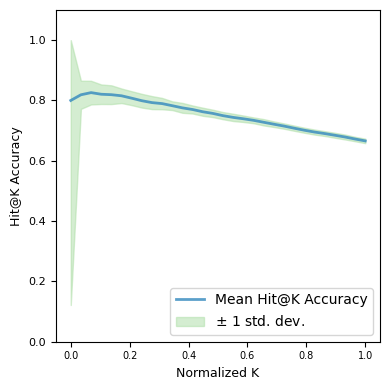

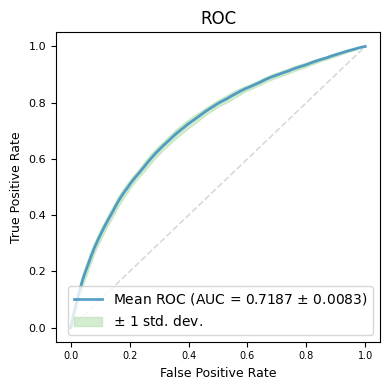

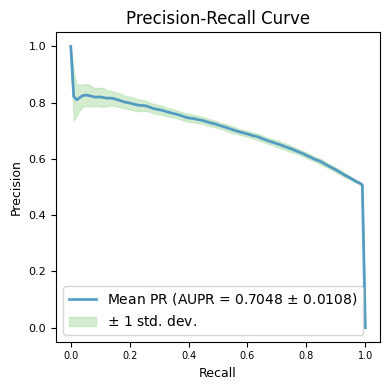

In [39]:
process_results(
    results=results,
    result_dir=RTM_RESULTS_DIR,
    dataset=dataset,
    train_balance_method=train_neg_samp_method,
    test_balance_method=test_balance_method,
    test_balance_kwargs=test_balance_kwargs,
)